# Thomas Fire

Author: Luna Herschenfeld-Catalan

Repository: https://github.com/lunacatalan/ca-thomas-fire

## About

In this notebook I will investigate the Thomas Fire that occured in California in 2017. I will create a time series graph to visualize the impact of the fire on the air quality index (AQI) of Santa Barbara County, and a false color image to understand the extent of the fire. 

## Highlights

- Data wrangling and exploration using `pandas`
- Geospatial analysis of false and true color images with `geopandas` and `rioxarray`
- Creating visualizations to give context for AQI measures as a result of the Thomas Fire

## Data Information

**Dataset 1: AQI**

In this task you will use [Air Quality Index (AQI)](https://www.airnow.gov/aqi/aqi-basics/) data from the [US Environmental Protection Agency](https://www.epa.gov) to visualize the impact on the AQI of the 2017 [Thomas Fire](https://en.wikipedia.org/wiki/Thomas_Fire) in Santa Barbara County. 

**Dataset 2: Landsat**

A simplified collection of bands (red, green, blue, near-infrared and shortwave infrared) from the Landsat Collection 2 Level-2 atmosperically corrected surface reflectance data, collected by the Landsat 8 satellite.

**Dataset 3:**

A shapefile of fire perimeters in California during 2017. 
The [complete file can be accessed in the CA state geoportal](https://gis.data.ca.gov/datasets/CALFIRE-Forestry::california-fire-perimeters-all-1/about).

# Final Output

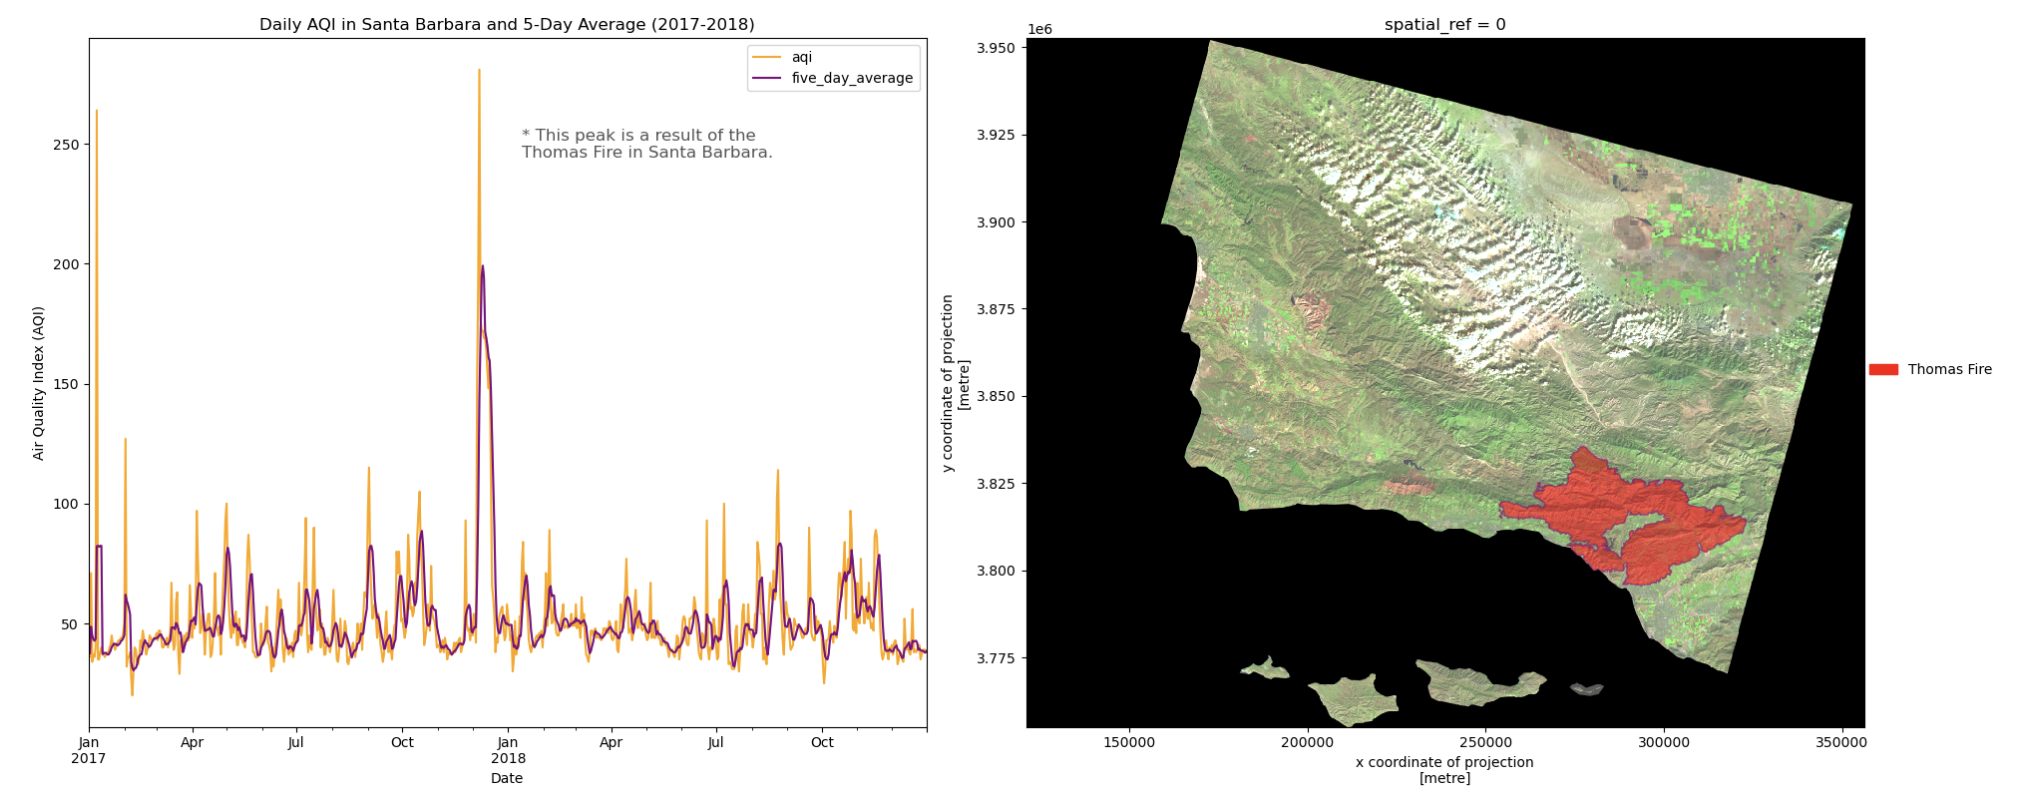

# Import Libraries

In [2]:
# import libraries
import pandas as pd
import matplotlib.pyplot as plt

import os 
import numpy as n


import xarray as xr
import rioxarray as rioxr
import geopandas as gpd

from shapely.geometry import box
import matplotlib.patches as mpatches # to create legends

# Import Data

In [3]:
# upload aqi data using url
aqi_17 = pd.read_csv('https://aqs.epa.gov/aqsweb/airdata/daily_aqi_by_county_2017.zip')
aqi_18 = pd.read_csv('https://aqs.epa.gov/aqsweb/airdata/daily_aqi_by_county_2018.zip')


# make filepath for landsat data
landsat_fp = os.path.join(os.getcwd(),
                          'data', 
                          "landsat8-2018-01-26-sb-simplified.nc")
# open raster
landsat = rioxr.open_rasterio(landsat_fp)

# read in california fire shapefile
ca_fire = gpd.read_file(os.path.join(os.getcwd(),
                                    'data',
                                    'California_Fire_Perimeters_2017',
                                    'California_Fire_Perimeters_2017.shp'))

# Prepare AQI Data

Since we want to investigate the data from both of these dataframes, we want to join them as a list of data frames using the `concat()` method. 

We can see that the dates now range from 2017 to 2018:

In [7]:
# join two dataframes as a list of data frames
aqi = pd.concat([aqi_17, aqi_18])
aqi

,State Name,county Name,State Code,County Code,Date,AQI,Category,Defining Parameter,Defining Site,Number of Sites Reporting
0,Alabama,Baldwin,1,3,2017-01-01,21,Good,PM2.5,01-003-0010,1
1,Alabama,Baldwin,1,3,2017-01-04,22,Good,PM2.5,01-003-0010,1
2,Alabama,Baldwin,1,3,2017-01-10,19,Good,PM2.5,01-003-0010,1
3,Alabama,Baldwin,1,3,2017-01-13,30,Good,PM2.5,01-003-0010,1
4,Alabama,Baldwin,1,3,2017-01-16,16,Good,PM2.5,01-003-0010,1
...,...,...,...,...,...,...,...,...,...,...
327532,Wyoming,Weston,56,45,2018-12-27,36,Good,Ozone,56-045-0003,1
327533,Wyoming,Weston,56,45,2018-12-28,35,Good,Ozone,56-045-0003,1
327534,Wyoming,Weston,56,45,2018-12-29,35,Good,Ozone,56-045-0003,1
327535,Wyoming,Weston,56,45,2018-12-30,31,Good,Ozone,56-045-0003,1


In [ ]:
# show updated dataframe size
print('length of the old dataframes: ', len(aqi_17), len(aqi_18))
print('updated length of combined dataframe: ', len(aqi))

length of the old dataframes:  326801 327537
updated length of combined dataframe:  654338


We also want to update the column names since they are annoying to work with in this format:

In [9]:
# rename column names with lowercase and add _ between words
aqi.columns = aqi.columns.str.lower().str.replace(' ','_')

## Data Selection

Now that we have a clean dataframe, we want to be able to select AQI information for Santa Barbara. We also dont want a lot of the other county information since we are only interested in SB, so we can drop those columns. 

Since we are interested in the AQI over time, we want to make sure that we can plot the time series correctly. To do that we want to check our data types to make sure that the date column is in the right format.

In [19]:
# select only SB county and drop column names
aqi_sb = aqi[aqi.county_name == 'Santa Barbara'].drop(['state_name', # drop these columns 
                                                       'county_name', 
                                                       'state_code', 
                                                       'county_code'], axis = 1)

aqi_sb.dtypes

date                         object
aqi                           int64
category                     object
defining_parameter           object
defining_site                object
number_of_sites_reporting     int64
dtype: object

As we can see above, the date column is not in the correct format. Since we are interested in plotting this data as time series, we want to make sure that the date column is in datetime so that it can plot correctly.

You can see that the date is now in datetime format!

In [20]:
# update date column to datetime type
aqi_sb['date'] = pd.to_datetime(aqi_sb['date'])

aqi_sb.dtypes

date                         datetime64[ns]
aqi                                   int64
category                             object
defining_parameter                   object
defining_site                        object
number_of_sites_reporting             int64
dtype: object

## Data Manipulation

In this step we are going to prepare the data for plotting by making calculating the 5 day average rolling mean to smooth the data and make it more understandable visually. 

To make plotting easier, we will first det the date column as the index. Then, we want to create a new column with the new 5 day average mean. 

In [21]:
# set date as index for easy plotting
aqi_sb = aqi_sb.set_index('date')

# create new column with 5 day mean
aqi_sb['five_day_average'] = aqi_sb.aqi.rolling('5D').mean()

# Prepare Landstat Data

First, we are going to investigate the raster layer to gain a sense of its dimensions and resolution.

In [31]:
# look at landsat data
print("bands:", landsat.band)
print('spatial bounding box:')
print(landsat.rio.bounds(), '\n')

height: 731
width: 870
resolution: (270.0, -270.0)
bands: <xarray.DataArray 'band' (band: 1)>
array([1])
Coordinates:
  * band         (band) int64 1
    spatial_ref  int64 0
spatial bounding box:
(121170.0, 3755160.0, 356070.0, 3952530.0) 



We can see that there is a single band. This will prove difficult to plot so we should remove it before we continue. 

Once we run the code below we can check raster again to see if the band was dropped:

In [32]:
# remove band dimension from lulc to be able to plot
landsat = landsat.squeeze().drop('band')

# check to see if the band was dropped
landsat

Before we continue with the landat data, we are going to explore the California Fire data so that we can make any necessary updates to be able to plot the landsat and ca fire data together. 

## Prepare CA Fire Data

First, we are going to compare the `crs` of the landsat and fire data to see if we have to make any updates.

Since these datasets have difference `crs`, we are are going to reproject the ca_fire data to the landsat data. 

In [35]:
# check crs
print(f"ca_fire: {ca_fire.crs}\nlandsat: {landsat.rio.crs}")

ca_fire: epsg:3857
landsat: EPSG:32611


In [36]:
# update fire crs to landsat crs
ca_fire = ca_fire.to_crs("EPSG:32611")

Now that that is done, we want to make sure that the ca_fire data is easy to work with.

The column names are all in caps and we have decided that that's annoying, so we want to update the column names. 

In [39]:
# check the columns and the number of values in the ca fire data frame
print("the column names are: ", ca_fire.columns)

# set all column names to lower case for easier wrangling 
ca_fire.columns = ca_fire.columns.str.lower()

## Data selection

We are only interested in mapping the Thomas fire that we have the AQI data for. In this next step, we want to only choose the Thomas fires from the california fire dataset. 

This will result in a single polygon:

In [43]:
# select only the Thomas Fires
thomas_fire = ca_fire[ca_fire.fire_name == 'THOMAS']
thomas_fire

,index,objectid,year_,state,agency,unit_id,fire_name,inc_num,alarm_date,cont_date,...,gis_acres,comments,complex_na,complex_in,irwinid,fire_num,decades,shape_leng,shape_area,geometry
436,20274,41874,2017,CA,USF,VNC,THOMAS,00003583,2017-12-04,2018-01-12,...,281790.875,CONT_DATE based on Inciweb,None,None,None,None,2010,540531.887458,1.681106e+09,"MULTIPOLYGON (((259241.263 3814482.913, 259193..."


# Updates before we can map 

We want to make it easy for viewers to understand what we are plotting. Selecting the bands below to create a flase color image of the landsat data will give us more information than a true color image. 

Plot the true color image and see what comes out:

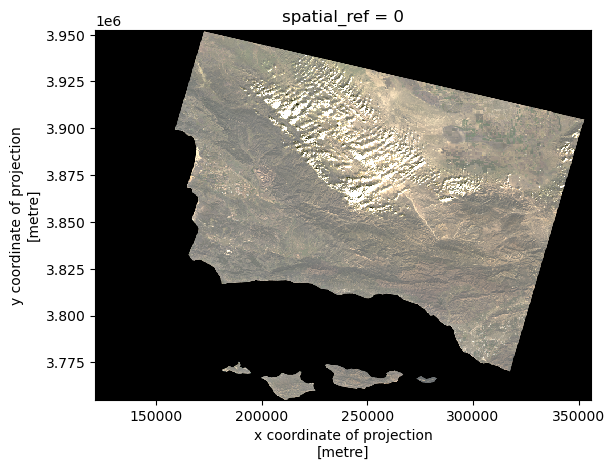

In [45]:
# select bands from landsat
landsat[["red", 
         "green", 
         "blue"]].to_array().plot.imshow(robust = True) 

This shows us the ground, but it is not clear what we are looking at. Is it trees? Grass?

Now, try mapping the false color image by plotting the short-wave infrared (swir22), near-infrared, and red variables (in that order):

In [48]:
# save false color image as an array
landsat_false = landsat[["swir22",
                         "nir08", # plot nir layer
                         "red"]].to_array()

# Map

Create a map that shows a geographic context for the spike in the AQI data plot during the Thomas Fire.

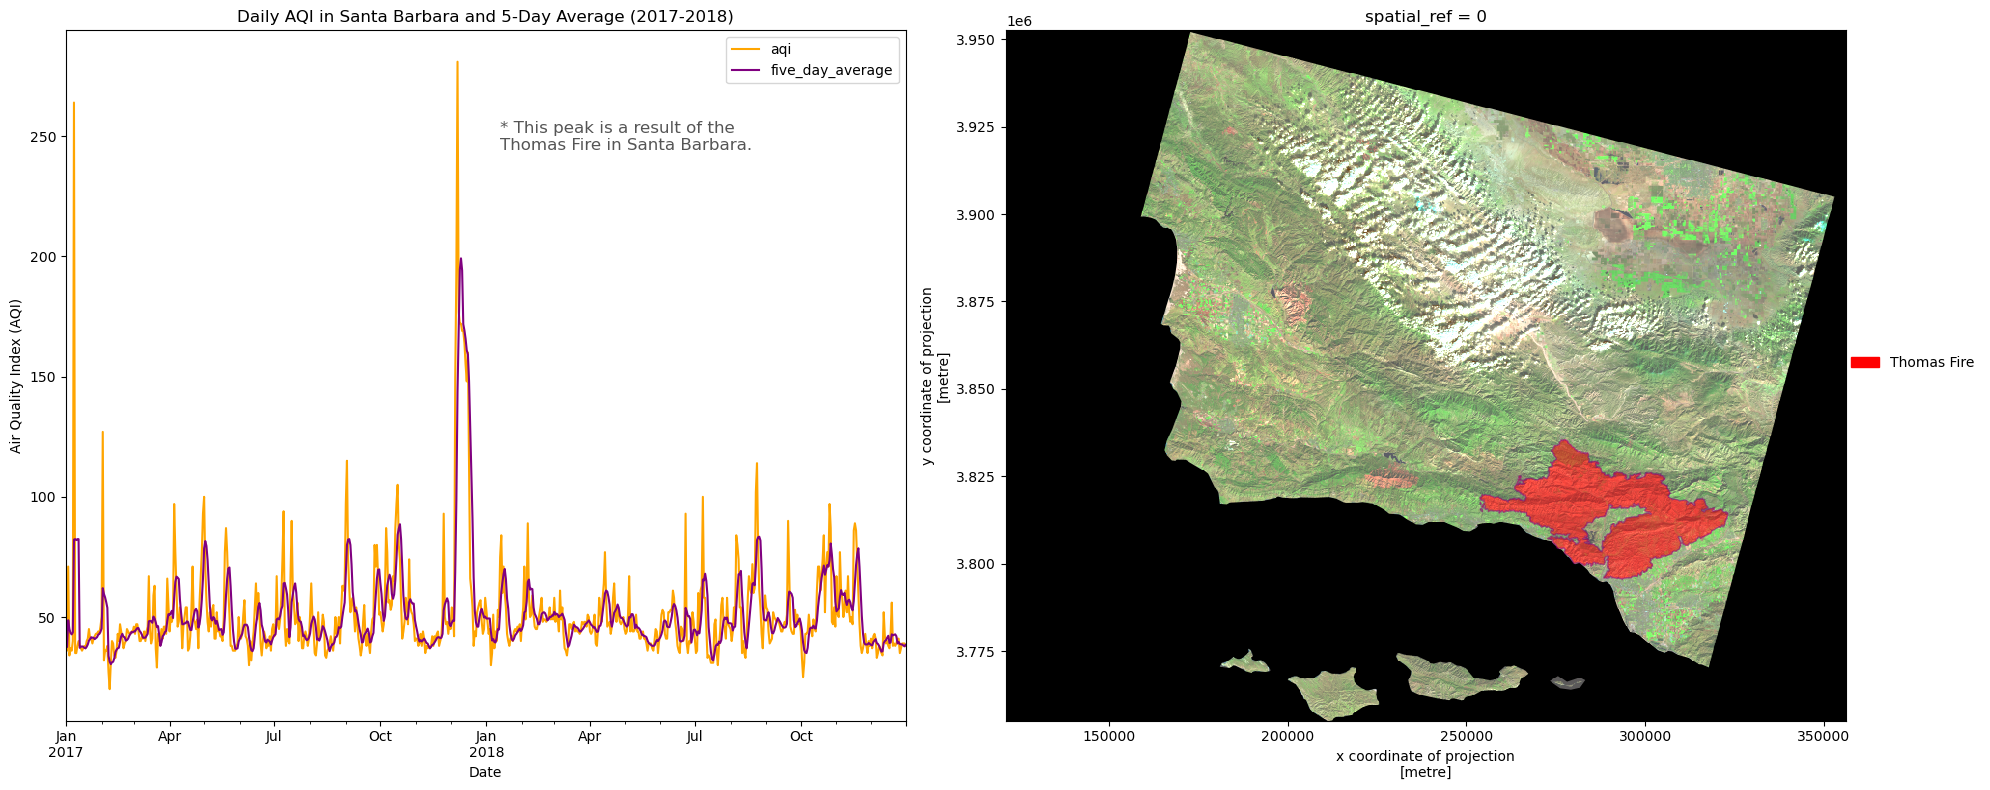

In [66]:
#---- Prepare Figure ----#

# plot the images in the same figure
fig, (ax1, ax2) = plt.subplots(1, 2, # set them up next to eachother
                               figsize = (20,8)) 

#---- Plot the aqi Data ----#

# plot daily aqi
aqi_sb.aqi.plot(ax = ax1, color = "orange", legend = True)

# plot 5 day average  aqi
aqi_sb.five_day_average.plot(ax = ax1, 
                             color = "purple", 
                             legend = True)

#---- Add axis labels ----#

# update axis labels/title
ax1.set_title('Daily AQI in Santa Barbara and 5-Day Average (2017-2018)')
ax1.set_xlabel('Date')
ax1.set_ylabel('Air Quality Index (AQI)')

#---- Plot the fire Data ----#

# plot the fires
thomas_fire.plot(ax = ax2,
                 color = "red",
                edgecolor = "purple", # make border around shapefile
                alpha = 0.5) # make transparent
fire_patch = mpatches.Patch(color = "red",
                          label = "Thomas Fire")

#---- Plot the Landsat Data ----#

# plot the false landsat
landsat_false.plot.imshow(ax = ax2,
                          robust = True) 

#---- Edit the Legend and Caption ----#

ax2.legend(handles = [fire_patch], # which labels to show 
          frameon = False, # no border around legend
          loc=(1, 0.5)) # where legend is located

ax1.annotate("* This peak is a result of the \nThomas Fire in Santa Barbara.", 
            xy=(0.25, 0.8), # position
            xycoords='figure fraction', 
            fontsize=12, 
            color='#555555') 
 
#---- Plot the whole figure  ----#

# space well
fig.tight_layout()
plt.show()

These figures show a plot of the AQI in Santa Barbara in the months before and after the Thomas Fire. This shows that there was a very large increase in the Aqir Quality index, sugesting that the quality of air declined significantly. The map on the right shows a visual of the area covered by tge Thomas Fire to give ccontext for the size of the fire that led to the AQI results in the graph.